In [4]:
!python --version
import os
import warnings


#suppress warnings
warnings.filterwarnings('ignore')

from dask.distributed import LocalCluster
cluster = LocalCluster()          # Fully-featured local Dask cluster
client = cluster.get_client()

client

Python 3.10.16


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40591/status,
Dashboard: http://127.0.0.1:40591/status,Workers: 7
Total threads: 28,Total memory: 62.58 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46253,Workers: 7
Dashboard: http://127.0.0.1:40591/status,Total threads: 28
Started: Just now,Total memory: 62.58 GiB
Comm: tcp://127.0.0.1:40517,Total threads: 4
Dashboard: http://127.0.0.1:46583/status,Memory: 8.94 GiB
Nanny: tcp://127.0.0.1:46765,


In [5]:
### use numba to speed up the code
from numba import jit

@jit(nopython=True)
def fast_function():
    pass


### Use Memory-Efficient Pandas Operations
import pandas as pd
pd.options.mode.chained_assignment = None  # Disable warnings
pd.set_option("display.float_format", "{:.2f}".format)  # Reduce memory usage



# 1. Workbook setups

## 1.1 Import packages

In [6]:
import pandas as pd
import numpy as np
import xarray as xr
xr.set_options(file_cache_maxsize=10)

import scipy as scipy
from scipy import stats
import math
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor

import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo

import proplot as plot

from shapely.geometry import Point, Polygon

from geopy.distance import distance, Distance, lonlat

from matplotlib import font_manager
font_manager.findfont("TeX Gyre Heros")
mpl.rcParams.update({'font.sans-serif':'TeX Gyre Heros',
                    'font.weight': 'normal',
                    'axes.labelweight': 'normal',
                    'axes.titleweight': 'normal',
                    'pdf.fonttype':42,
                    'ps.fonttype':42
                     })

import string
import os
import requests
import io
from tqdm import tqdm
import time

## 1.2 Miscellaneous codes

In [7]:
def round_to_nearest_half_int(num):
    return round(num * 2) / 2

def getClosestPoint_fromLineString(LineString_input,point1):
    if "MultiLineString" in str(type(LineString_input)):
        multiLineString = LineString_input
        len_multiLineString = len(multiLineString.geoms)
        idxMin = np.array([multiLineString.geoms[i].distance(point1) for i in range(len_multiLineString)]).argmin()
        
        LineString = multiLineString.geoms[idxMin]
    elif "Polygon" in str(type(LineString_input)):
        
        polygon_input = LineString_input
        LineString = polygon_input.exterior
        
    else:
        LineString = LineString_input
        
    Coords = LineString.coords
    x, y = Coords.xy

    coords_df = pd.DataFrame({'LON':x,'LAT':y})
    coords_df['LAT_diff'] = abs(point1.y-coords_df.LAT)
    coords_df['LON_diff'] = abs(point1.x-coords_df.LON)
    coords_df['LONLAT_diff_sum'] = coords_df['LAT_diff']+coords_df['LON_diff']
    lat2,lon2 = coords_df.LAT.iloc[coords_df.LONLAT_diff_sum.idxmin()],coords_df.LON.iloc[coords_df.LONLAT_diff_sum.idxmin()]
    point2 = Point(lon2,lat2)
    return point2

def distance_haversine(origin, destination, output_unit='km'):
    import math
    lon1, lat1 = origin
    lon2, lat2 = destination
    
    if output_unit=='km':
        radius = 6371
    elif output_unit=='mi':
        radius = 3956
    elif output_unit=='m':
        radius = 6371000
    
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c
    return d

# Define usefull functions:
def vrange(V): # Return the array value range
    return [np.min(V),np.max(V)]
def vrangec(V): # Return the array value centered range 
    xl = np.max(np.abs(vrange(V)))
    return np.array([-xl,xl])

def nonnan_gradient(array, axis=None, edge_order=1):
  """Computes the gradient of an array, ignoring NaN values.

  Args:
    array: An N-dimensional array containing samples of a scalar function.
    axis: The axis along which to compute the gradient. If None, the gradient
      is computed for all axes.
    edge_order: The order of the accuracy of the approximation at the edges of
      the array.

  Returns:
    An N-dimensional array or a list of N-dimensional arrays representing the
    gradient.
  """

  # Create a mask of non-NaN values.
  mask = np.isfinite(array)

  # Compute the gradient of the masked array.
  gradient = np.gradient(array, axis=axis, edge_order=edge_order)

  # Set the gradient to zero wherever the mask is False.
  for i in range(len(gradient)):
    gradient[i][~mask] = 0

  return gradient

## 1.3 Dictionaries

In [8]:
ringNumbers_dict_zhang16 = {
    'reported_1302':0, 
    'fGDGT_0':0,
    'reported_1300':1,
    'fGDGT_1':1, 
    'reported_1298':2,
    'fGDGT_2':2, 
    'reported_1296':3,
    'fGDGT_3':3,
    'reported_1294':4,
    'fGDGT_4':4,
    'reported_1294_iso':4,
    'fGDGT_4_prime':4,
    'reported_1292':4, 
    'fGDGT_cren':4,
    'reported_1292_iso':4,
    'fGDGT_cren_prime':4,
    'reported_1292_iso2':5,
    'fGDGT_5':5,
    'reported_1290':6,
    'fGDGT_6':6,
    'reported_1290_iso':6,
    'fGDGT_6_prime':6,
    'reported_1288':7,
    'fGDGT_7':7,
    'reported_1288_iso':7,
    'fGDGT_7_prime':7,
    'reported_1286':8,
    'fGDGT_8':8,
    'reported_1286_iso':8,
    'fGDGT_8_prime':8,
}

ringNumbers_dict_revised = {
    'reported_1302':0, 
    'fGDGT_0':0,
    'reported_1300':1,
    'fGDGT_1':1, 
    'reported_1298':2,
    'fGDGT_2':2, 
    'reported_1296':3,
    'fGDGT_3':3,
    'reported_1294':4,
    'fGDGT_4':4,
    'reported_1294_iso':4,
    'fGDGT_4_prime':4,
    'reported_1292':5, 
    'fGDGT_cren':5,
    'reported_1292_iso':5,
    'fGDGT_cren_prime':5,
    'reported_1292_iso2':5,
    'fGDGT_5':5,
    'reported_1290':6,
    'fGDGT_6':6,
    'reported_1290_iso':6,
    'fGDGT_6_prime':6,
    'reported_1288':7,
    'fGDGT_7':7,
    'reported_1288_iso':7,
    'fGDGT_7_prime':7,
    'reported_1286':8,
    'fGDGT_8':8,
    'reported_1286_iso':8,
    'fGDGT_8_prime':8,
}


def label_pvalues(x):
    if x<0.001:
        return r'$\it{p}$<.001'
    elif x<0.01:
        return r'$\it{p}$<.01'
    elif x<0.05:
        return r'$\it{p}$<.05'
    elif x<0.1:
        return r'$\it{p}$<.1'
    elif x>=0.1:
        return r'$\it{p}$>.1'


## 1.4 Set local paths

In [9]:
# set the path to local folder other than github
login_name = os.getlogin()
### 1.4.1 Local path on PC
local_documents_path = f'/home/{login_name}/Documents' ### this is the path when code is run on Linux

### 1.4.2 Path to github folder
gitpath_idx = os.getcwd().find('nutrient-effect-on-TEX')+len('nutrient-effect-on-TEX')
local_github_path = os.getcwd()[:gitpath_idx]

### 1.4.3 Path to OneDrive folder
local_onedrive_path = f'/home/{login_name}/OneDrive'

# 2. Import data

## 2.1 Coretop compilation

In [7]:
fpath = os.path.join(local_github_path,'spreadsheets')
fname = r'ds01_updated_global_coretop_tex.csv'

coretop_df = pd.read_csv(os.path.join(fpath,fname))

coretop_df = coretop_df.rename(
    columns={
        'latitude':'Latitude',
        'longitude':'Longitude',
        'depth':'modernWaterDepth',
        'tex86':'TEX86',
        'bit':'BIT'
    }
)

#### Additional parameters
coretop_df['publicationYear'] = [int(row[-4:]) if row[-4:].isdigit() else 'This Study' for row in coretop_df['reference_name']]
Tierney2015SciAdv_idx = coretop_df[coretop_df['reference_name']=='Tierney2015SciAdv'].index
coretop_df.loc[Tierney2015SciAdv_idx,'publicationYear'] = 2015
thisStudy_idx = coretop_df[coretop_df['publicationYear']=='This Study'].index
coretop_df.loc[thisStudy_idx,'publicationYear'] = 2025
coretop_df['publicationYear'] = coretop_df['publicationYear'].astype(int)
features = ['fGDGT_0', 'fGDGT_1', 'fGDGT_2', 'fGDGT_3','fGDGT_cren', 'fGDGT_cren_prime']
coretop_df['ringIndex'] = np.array([coretop_df[features[i]]*ringNumbers_dict_zhang16.get(features[i]) for i in range(len(features))]).sum(axis=0)
coretop_df['gdgt23ratio'] = coretop_df['fGDGT_2']/coretop_df['fGDGT_3']
coretop_df['methaneIndex'] = coretop_df[['fGDGT_1', 'fGDGT_2', 'fGDGT_3']].sum(axis=1)/coretop_df[['fGDGT_1', 'fGDGT_2', 'fGDGT_3','fGDGT_cren', 'fGDGT_cren_prime']].sum(axis=1)
coretop_df['gdgtZeroOverZeroCren'] = (coretop_df['fGDGT_0']/coretop_df[['fGDGT_0','fGDGT_cren']].sum(axis=1))

temp_sampleID = ['RR'+str(i).zfill(5) for i in range(1,len(coretop_df)+1)]
coretop_df.insert(0,'sampleID',temp_sampleID)

#### copy coretop_df to coretop_df2 to keep the original df
coretop_df2 = coretop_df.dropna(how='any', subset=['TEX86']).reset_index(drop=True)
coretop_df2['BIT'] = coretop_df2['BIT'].fillna(-999)
coretop_df2['methaneIndex']= coretop_df2['methaneIndex'].fillna(-999)
coretop_df2['gdgtZeroOverZeroCren'] = coretop_df2['fGDGT_0'].fillna(-999)

coretop_df2['TEX_RI'] = (-0.77*coretop_df2['TEX86']
                                )+(3.32*coretop_df2['TEX86']**2
                                   )+(1.59)
coretop_df2['deltaRI'] = coretop_df2['TEX_RI']-coretop_df2['ringIndex']


coretop_df2['QC_flag'] = ['include' if ((coretop_df2['BIT'].iloc[i] <= 0.5) & (coretop_df2['methaneIndex'].iloc[i] <= 0.5) & (coretop_df2['gdgtZeroOverZeroCren'].iloc[i] <= 0.67)) else 'exclude' for i in range(len(coretop_df2))]
coretop_df2

,sampleID,index_column,core_name,core_type,sample_depth_start,sample_depth_end,Latitude,Longitude,modernWaterDepth,TEX86,...,remark,reference_link,dataset_DOI,ringIndex,gdgt23ratio,methaneIndex,gdgtZeroOverZeroCren,TEX_RI,deltaRI,QC_flag
0,RR00001,JET_RR_00001,GeoB7702-3,GC,5.00,6.00,31.65,34.07,562.00,0.66,...,Data published in Tierney & Tingley (2015),http://dx.doi.org/10.1029/2009PA001740,'https://doi.org/10.25921/wt2r-sc81,NaN,NaN,-999.00,-999.00,2.54,NaN,include
1,RR00002,JET_RR_00002,KNR195-5-5 MC11,MC,6.00,8.00,-1.53,-86.79,2288.00,0.60,...,Reanalysed samples of Chazen2011 by this study,NaN,10.5281/zenodo.14806962,2.34,13.19,0.20,0.33,2.33,-0.01,include
2,RR00003,JET_RR_00003,KNR195-5-6 MC12,MC,0.00,1.00,-3.71,-81.12,378.00,0.57,...,Data published in Tierney & Tingley (2015),https://repository.library.brown.edu/studio/it...,'https://doi.org/10.25921/wt2r-sc81,NaN,NaN,-999.00,-999.00,2.23,NaN,include
3,RR00004,JET_RR_00004,KNR195-5-7 MC16,MC,0.00,1.00,-3.75,-81.14,379.00,0.57,...,Data published in Tierney & Tingley (2015),https://repository.library.brown.edu/studio/it...,'https://doi.org/10.25921/wt2r-sc81,NaN,NaN,-999.00,-999.00,2.24,NaN,include
4,RR00005,JET_RR_00005,KNR195-5-8 MC18,MC,4.00,6.00,-3.97,-81.31,1024.00,0.60,...,Reanalysed samples of Chazen2011 by this study,NaN,10.5281/zenodo.14806962,2.57,4.88,0.18,0.28,2.32,-0.25,include
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2097,RR02100,JET_RR_02100,AMD17_BB2_BC,NaN,NaN,NaN,72.75,-67.02,2373.00,0.35,...,Data from original source,https://doi.org/10.5194/bg-20-229-2023,https://doi.org/10.1594/PANGAEA.956212,1.17,5.50,0.14,0.68,1.72,0.55,exclude
2098,RR02101,JET_RR_02101,AMD17_CASQ1_BC-4,NaN,NaN,NaN,71.41,-70.89,702.00,0.35,...,Data from original source,https://doi.org/10.5194/bg-20-229-2023,https://doi.org/10.1594/PANGAEA.956212,1.30,3.00,0.04,0.66,1.73,0.43,include
2099,RR02102,JET_RR_02102,AMD17_176_BC,NaN,NaN,NaN,69.60,-65.40,267.00,0.40,...,Data from original source,https://doi.org/10.5194/bg-20-229-2023,https://doi.org/10.1594/PANGAEA.956212,1.19,3.00,0.04,0.69,1.81,0.62,exclude
2100,RR02103,JET_RR_02103,AMD17_8.1_BC,NaN,NaN,NaN,69.41,-64.40,1054.00,0.32,...,Data from original source,https://doi.org/10.5194/bg-20-229-2023,https://doi.org/10.1594/PANGAEA.956212,1.09,6.00,0.10,0.71,1.69,0.60,exclude


## 2.2 Ocean products

### 2.2.1 WOA23 - Temperature 0.25deg x 0.25deg

WOA = World Ocean Atlas
Details:
- Temperature - Statistical mean on 1/4° grid for 1991-2020 climate normal
- Unit: Degree Celcius
- Link to download data: https://www.ncei.noaa.gov/thredds-ocean/fileServer/woa23/DATA/temperature/netcdf/decav91C0/0.25/woa23_decav91C0_t00_04.nc

In [8]:
fpath2 = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/WOA-decav'
ts = xr.open_dataset(os.path.join(fpath2,'woa23_decav91C0_t00_04.nc'),decode_times=False).drop('time')

T_da = ts.isel(time=0).t_an.load()
T_da

<xarray.DataArray 't_an' (depth: 102, lat: 720, lon: 1440)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.6605101, -1.66081  , -1.65491  , ..., -1.6598101,
         -1.66031  , -1.66041  ],
        [-1.66861  , -1.66521  , -1.66721  , ..., -1.66961  ,
         -1.6665   , -1.66871  ],
        [-1.44921  , -1.44921  , -1.44921  , ..., -1.44921  ,
         -1.44921  , -1.44921  ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius

#### Calculate gridded thermocline depth and depth-integrated thermocline T with xarray

In [9]:
### calculate thermocline along depth dimension of T_da using min T gradient approach (depth with the fastest drop in T)
### calculate using diff method from xarray and divide by the diff of depth
sliced_T_da = T_da.sel(depth=slice(0,1100))
gradient = sliced_T_da.diff('depth')/sliced_T_da.depth.diff('depth')

### mask NaN values
gradient = abs(gradient.where(~np.isnan(T_da)))

### fill NaN values with infinity to avoid error in argmin
gradient_filled = gradient.fillna(-np.inf)
maxabs_gradient_idx = gradient_filled.argmax('depth',skipna=True).astype(int)+1

### mask locations where all depth values are NaN
all_nan_mask = np.isnan(sliced_T_da).all('depth')

### mask maxabs_gradient_idx where all depth values are NaN
maxabs_gradient_idx = maxabs_gradient_idx.where(~all_nan_mask, drop=False)

# Flatten the lat-lon grid for advanced indexing
stacked = sliced_T_da.stack(grid=["lat", "lon"])

# Ensure maxabs_gradient_idx is an integer, replacing NaN with a valid placeholder index (e.g., 0)
valid_idx = maxabs_gradient_idx.fillna(0).astype(int)

# Use isel to index the depth dimension with the flattened indices
thermoT_depth_values = stacked["depth"].isel(depth=valid_idx.stack(grid=["lat", "lon"]))
thermoT_values = stacked.isel(depth=valid_idx.stack(grid=["lat", "lon"]))
# Mask locations where maxabs_gradient_idx was NaN
nan_mask = maxabs_gradient_idx.isnull()
thermoT_depth_values = thermoT_depth_values.where(~nan_mask.stack(grid=["lat", "lon"]))
thermoT_values = thermoT_values.where(~nan_mask.stack(grid=["lat", "lon"]))
# Unstack to return to the original lat-lon dimensions
thermoT_depth_da = thermoT_depth_values.unstack("grid")
thermoT_da = thermoT_values.unstack("grid")
masked_T_da = T_da.where(T_da["depth"]<=thermoT_depth_da)


In [10]:
len_notnull_values_along_depth = np.unique(masked_T_da.notnull().sum('depth').values)
sel_masked_da = masked_T_da
tmp_da = xr.DataArray(np.zeros_like(sel_masked_da.isel(depth=0).values),
                      dims=sel_masked_da.isel(depth=0).dims,
                      coords=sel_masked_da.isel(depth=0).coords
                      )
tmp_da
# Loop through the unique counts of non-NaN values along depth
for i in len_notnull_values_along_depth:
    if i == 0:
        continue  # Skip cases where no valid data is available
    # Select grid points where the non-NaN count equals `i`
    mask = sel_masked_da.notnull().sum('depth') == i
    
    if i == 1:
        # if only one valid depth slice, use the first depth slice
        cal_values = (
            sel_masked_da.where(sel_masked_da.notnull().sum('depth') == i)
            .isel(depth=0)
        )
    else:
        # Calculate the integrated values for the valid depth slices
        cal_values = (
            sel_masked_da.where(sel_masked_da.notnull().sum('depth') == i)
            .isel(depth=slice(0, i))
            .integrate('depth')
        )
        
        # Update tmp_da with the calculated values at the same grid points
    tmp_da = tmp_da.where(~mask, other=cal_values)
tmp_da2 = tmp_da
#### mask locations where there are more than 1 valid depth values
mask_below_SST = sel_masked_da.notnull().sum('depth') > 1
cal_values = tmp_da2.where(mask_below_SST)/thermoT_depth_da.where(mask_below_SST)
# apply mask where all depth values are NaN
all_nan_mask = np.isnan(sel_masked_da).all('depth')
tmp_da2 = tmp_da2.where(~all_nan_mask)

thermocline_depthIntegral_T_da = tmp_da2.where(~mask_below_SST, other=cal_values)
thermocline_depthIntegral_T_da

<xarray.DataArray (lat: 720, lon: 1440)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [-1.259286 , -1.2593093, -1.2591022, ..., -1.2571529, -1.2572602,
        -1.2578851],
       [-1.2703198, -1.2704593, -1.270767 , ..., -1.2695758, -1.2696911,
        -1.2696723],
       [-1.2687643, -1.2687643, -1.2687643, ..., -1.2687643, -1.2687643,
        -1.2687643]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    depth    float32 0.0

#### Spot-checking core sites near coastlines

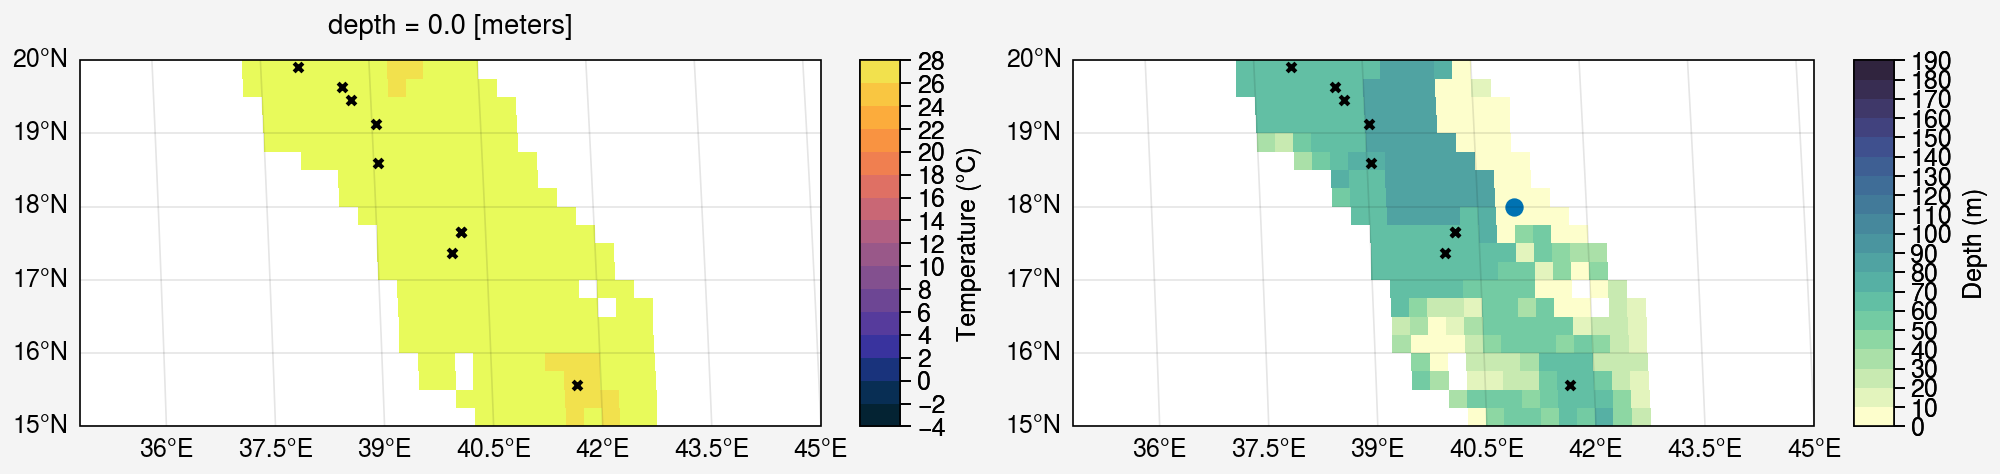

In [11]:
fig, axs = plot.subplots(proj='eck3',
                         width=10,ncols=2)
axs.format(
    latlim=(15,20),
    lonlim=(35,45),
    latlabels=True,lonlabels=True
)

ax = axs[0]
thermocline_depthIntegral_T_da.plot(ax=ax,robust=True,
                                    cmap=cmo.thermal,
                                    levels=np.arange(-4,30,2),
                                    cbar_kwargs={'label':'Temperature (°C)'}
                                    )

ax.scatter(coretop_df2['Longitude'],coretop_df2['Latitude'],s=10,c='k',marker='x',label='Coretops')

ax = axs[1]
thermoT_depth_da.plot(ax=ax,robust=True,
                cmap=cmo.deep,
                levels=np.arange(0,200,10),
                cbar_kwargs={'label':'Depth (m)'}
                )

ax.scatter(coretop_df2['Longitude'],coretop_df2['Latitude'],s=10,c='k',marker='x',label='Coretops')
ax.scatter(41,18)

### 2.2.2 CMEMS Nitrate

CMEMS = Copernicus Marine Environmental Monitoring Service

- Nitrate - Mole concentration of nitrate in sea water 0.25deg x 0.25deg
- Unit: mmol/m3
- Link to data product website: https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_BGC_001_029/description

- Raw data: monthly climatology hindcasts from 1993-2022 (30 years)
- Processing: The climatology mean field of annual average were generated from 30-year montly climatologies using ncclimo function (https://nco.sourceforge.net/nco.html)

In [22]:
fpath = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/WOA-decav'
fname = 'woa23_all_n00_01.nc'

woa23_nitrate = xr.open_dataset(os.path.join(fpath,fname),decode_times=False).drop('time')
woa23_nitrate = woa23_nitrate.isel(time=0).n_an.load()
woa23_nitrate

<xarray.DataArray 'n_an' (depth: 102, lat: 180, lon: 360)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.5065072 , 0.5077519 , 0.50824255, ..., 0.49354407,
         0.49962154, 0.50394267],
        [0.5509077 , 0.552426  , 0.55362046, ..., 0.53350955,
         0.5418536 , 0.54766   ],
        [0.5734835 , 0.5734835 , 0.5734835 , ..., 0.5734835 ,
         0.5734835 , 0.5734835 ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
Attributes:
    standard_name:  moles_of_nitrate_per_unit_mass_in_sea_water
    long_name:      Objectively analyzed mean fields for moles_of_nitrate_per...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          micromoles_per_kilogram

In [12]:
### NEMO nitrate data
fpath = fr'{local_onedrive_path}/Postdoc/Project/TEXAS/netcdf/Copernicus Marine Service/processed-files/Global-Biogeochemistry/climo-monthly/no3'
fname = r'mercatorfreebiorys2v4_global_mean_ANN_199301_202212_climo.nc'

nitrate_CMEMS_ds = xr.open_dataset(os.path.join(fpath,fname))
nitrate_CMEMS_ds = nitrate_CMEMS_ds.isel(time=0).drop('time')
nitrate_CMEMS_ds = nitrate_CMEMS_ds.rename({'latitude':'lat','longitude':'lon'})
nitrate_CMEMS_da = nitrate_CMEMS_ds.no3.load() ### convert mmol/L to umol/L to make it comparable to WOA data
nitrate_CMEMS_da

depth_coord = nitrate_CMEMS_da.depth
depth_coord = depth_coord - depth_coord[0]
nitrate_CMEMS_da = nitrate_CMEMS_da.assign_coords(depth=depth_coord)
nitrate_CMEMS_da

<xarray.DataArray 'no3' (depth: 75, lat: 681, lon: 1440)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [5.7781367, 5.779535 , 5.7808266, ..., 5.7733583, 5.775043 ,
         5.7766376],
        [5.720044 , 5.7206492, 5.721291 , ..., 5.718462 , 5.7189493,
         5.719477 ],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float32 -80.0 -79.75 -79.5 -79.25 ... 89.25 89.5 89.75 90.0
  * depth    (depth) float32 0.0 1.05 2.162 ... 5.494e+03 5.698e+03 5.902e+03
Attributes:
    long_name:      Nitrate
    standard_name:  mole_concentration_of_nitrate_in_sea_water
    units:          mmol m-3
    unit_long:      millimoles of Nitrate per cubic meter
    valid_min:      0.0
    valid_max:      59.31268
    cell_methods:   time: mean

In [13]:
### regrid nitrate_CMESM to T_an grid
nitrate_CMEMS_da_regrid_lld = nitrate_CMEMS_da.interp(lat=T_da.lat,lon=T_da.lon,depth=T_da.depth,method='linear')
nitrate_CMEMS_da_regrid_lld 

<xarray.DataArray 'no3' (depth: 102, lat: 720, lon: 1440)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [5.7811136, 5.7841377, 5.7870884, ..., 5.771783 , 5.774918 ,
               nan],
        [5.749591 , 5.750575 , 5.751523 , ..., 5.7464533, 5.7475266,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
Attributes:
    long_name:      Nitrate
    standard_name:  mole_concentration_of_nitrate_in_sea_water
    units:          mmol m-3
    unit_long:      millimoles of Nitrate per cubic meter
    valid_min:      0.0
    valid_max:      59.31268
    cell_methods:   time: mean

In [14]:
masked_nitrate_regrid_lld_da = nitrate_CMEMS_da_regrid_lld.where(nitrate_CMEMS_da_regrid_lld["depth"]<=thermoT_depth_da)
masked_tmp_grid = masked_nitrate_regrid_lld_da
len_notnull_values_along_depth = np.unique(masked_tmp_grid.notnull().sum('depth').values)
tmp_da = xr.DataArray(np.zeros_like(masked_tmp_grid.isel(depth=0).values),
                      dims=masked_tmp_grid.isel(depth=0).dims,
                      coords=masked_tmp_grid.isel(depth=0).coords
                      )
tmp_da2 = xr.DataArray(np.zeros_like(masked_tmp_grid.isel(depth=0).values),
                        dims=masked_tmp_grid.isel(depth=0).dims,
                        coords=masked_tmp_grid.isel(depth=0).coords
                        )
# Loop through the unique counts of non-NaN values along depth
for i in len_notnull_values_along_depth:
    if i == 0:
        continue  # Skip cases where no valid data is available
    # Select grid points where the non-NaN count equals `i`
    mask = masked_tmp_grid.notnull().sum('depth') == i
    
    if i == 1:
        # if only one valid depth slice, use the first depth slice
        cal_values = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=0)
        )
        cal_values2 = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=0)
        )
    else:
        # Calculate the integrated values for the valid depth slices
        cal_values = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=slice(0, i))
            .integrate('depth')
        )
        ### grab last value of nitrate
        cal_values2 = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=slice(0, i))
            .isel(depth=i-1)
        )
    # Update tmp_da with the calculated values at the same grid points
    tmp_da = tmp_da.where(~mask, other=cal_values)
    tmp_da2 = tmp_da2.where(~mask, other=cal_values2)

#### mask locations where there are more than 1 valid depth values
mask_below_surface = masked_tmp_grid.notnull().sum('depth') > 1
cal_values = tmp_da.where(mask_below_surface)/thermoT_depth_da.where(mask_below_surface)

# apply mask where all depth values are NaN
all_nan_mask = np.isnan(masked_tmp_grid).all('depth')
tmp_da = tmp_da.where(~all_nan_mask)
thermocline_depthIntegral_nitrate_da = tmp_da
thermocline_depthIntegral_nitrate_da = thermocline_depthIntegral_nitrate_da.where(~mask_below_surface, other=cal_values)
display(thermocline_depthIntegral_nitrate_da)

tmp_da2 = tmp_da2.where(~all_nan_mask)
thermocline_nitrate_da = tmp_da2
display(thermocline_nitrate_da)


<xarray.DataArray (lat: 720, lon: 1440)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [7.5698457, 7.572421 , 7.5749416, ..., 7.561945 , 7.5645914,
              nan],
       [7.498859 , 7.4996924, 7.500496 , ..., 7.496213 , 7.4971166,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    depth    float32 0.0

<xarray.DataArray (lat: 720, lon: 1440)>
array([[     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       ...,
       [9.325234, 9.326268, 9.32728 , ..., 9.322065, 9.323127,      nan],
       [9.300414, 9.300759, 9.301102, ..., 9.299388, 9.299727,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    depth    float32 1e+03

#### Figure S2. Comparison between original and re-gridded CMEMS nitrates

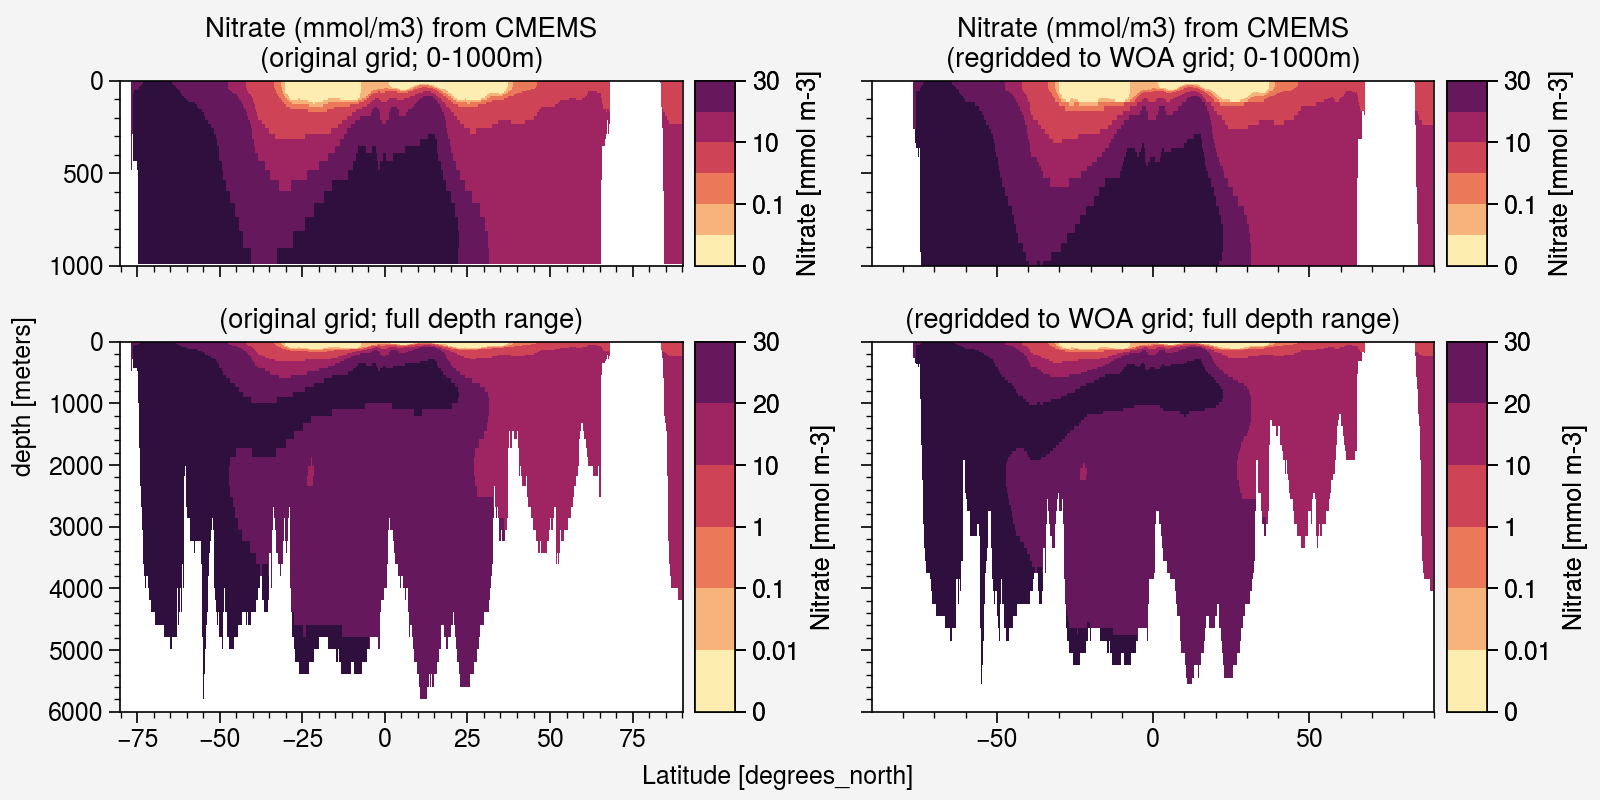

In [15]:
fig, axs = plot.subplots(nrows=2,ncols=2,figsize=(8,4),hratios=[1,2])
sel_lon = -30
ax = axs[0,0]
nitrate_CMEMS_da.sel(depth=slice(0,1000)).sel(lon=sel_lon,method='nearest').plot(ax=ax,cmap='matter',levels=[1e-2,1e-1,0,1,10,20,30])
ax.set_title('Nitrate (mmol/m3) from CMEMS\n(original grid; 0-1000m)')
ax.format(ylim=(1000,0))

ax = axs[0,1]
nitrate_CMEMS_da_regrid_lld.sel(depth=slice(0,1000)).sel(lon=sel_lon,method='nearest').plot(ax=ax,cmap='matter',levels=[1e-2,1e-1,0,1,10,20,30])
ax.set_title('Nitrate (mmol/m3) from CMEMS\n(regridded to WOA grid; 0-1000m)')
ax.format(ylim=(1000,0))

ax = axs[1,0]
nitrate_CMEMS_da.sel(lon=sel_lon,method='nearest').plot(ax=ax,cmap='matter',levels=[1e-2,1e-1,0,1,10,20,30])
ax.set_title('(original grid; full depth range)')
ax.format(ylim=(6000,0))

ax = axs[1,1]
nitrate_CMEMS_da_regrid_lld.sel(lon=sel_lon,method='nearest').plot(ax=ax,cmap='matter',levels=[1e-2,1e-1,0,1,10,20,30])
ax.set_title('(regridded to WOA grid; full depth range)')
ax.format(ylim=(6000,0))

fpath = fr'{local_github_path}/figures/'
fname = 'Fig_S2_CESM_nitrate_profiles.pdf'

# axs.format(suptitle='An example of CMEMS nitrate zonal cross section along 30$\degree$ longitude')
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight',embed_fonts=True,rasterized=True)

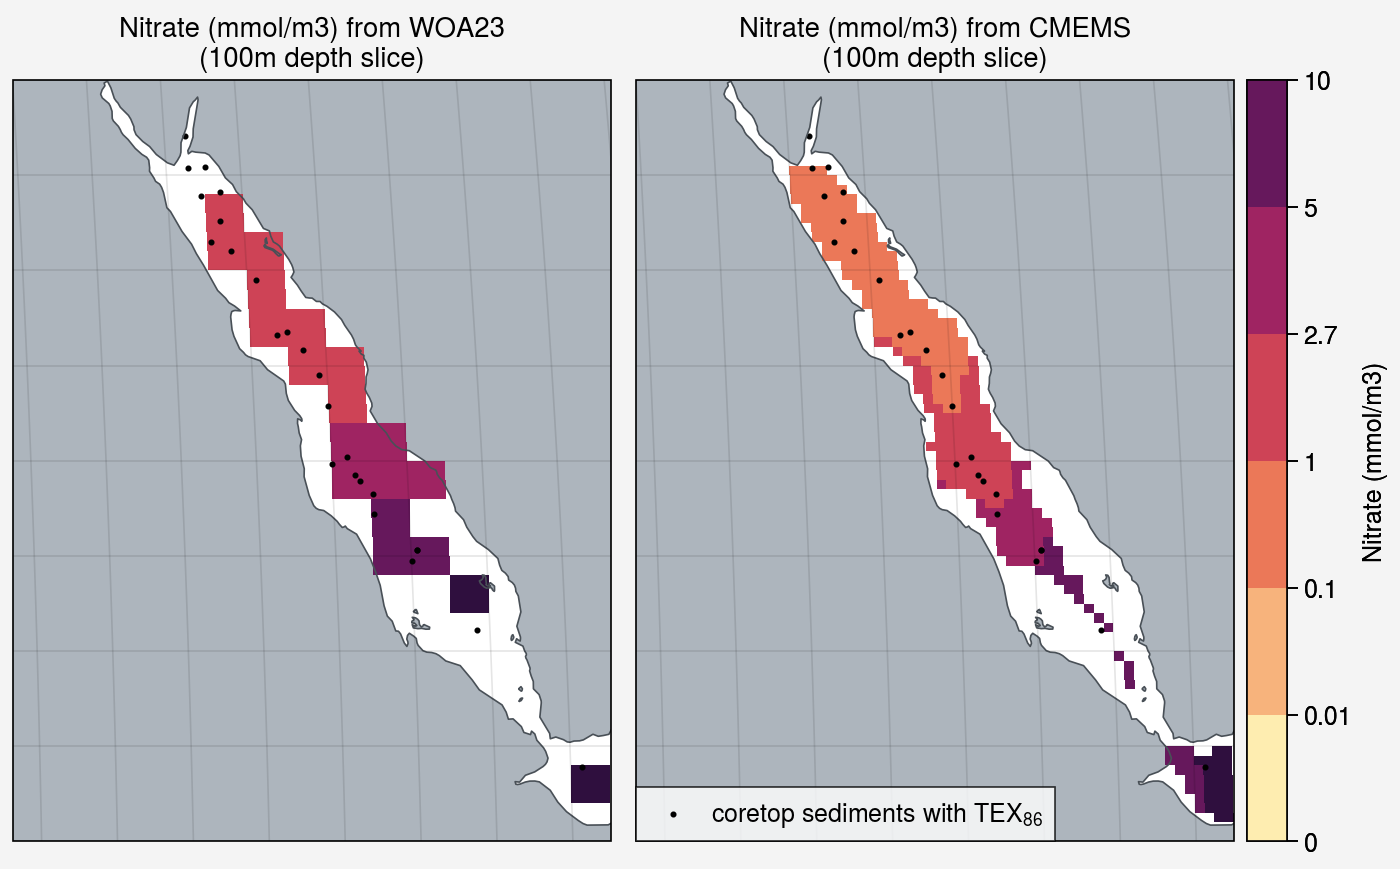

In [50]:
fig, axs = plot.subplots(ncols=2,proj='eck3',width=7)
axs.format(reso='med',land=True, landcolor='gray5',landzorder=0,
           coast=True,coastcolor='gray7',coastzorder=1,
           latlim=(10,30),lonlim=(30,45),
)

ax = axs[0]
woa23_nitrate.sel(depth=100,method='nearest').sel(lat=slice(10,30),lon=slice(30,45)).plot(ax=ax,
                                    cmap='matter',
                                    levels=[1e-2,1e-1,0,1,2.7,5,10],
                                    # robust=True,
                                    add_colorbar=False,
                                    )
ax.set_title('Nitrate (mmol/m3) from WOA23\n(100m depth slice)')
ax = axs[1]
nitrate_CMEMS_da_regrid_lld.sel(depth=100,method='nearest').sel(lat=slice(10,30),lon=slice(30,45)).plot(ax=ax,
                                    cmap='matter',
                                    levels=[1e-2,1e-1,0,1,2.7,5,10],
                                    # robust=True,
                                    cbar_kwargs={'label':'Nitrate (mmol/m3)'}
                                    )
ax.set_title('Nitrate (mmol/m3) from CMEMS\n(100m depth slice)')

plot_data = coretop_df2[['Longitude','Latitude']].dropna(how='any')
axs.scatter(plot_data['Longitude'],plot_data['Latitude'],s=10,c='k',marker='.',label='Coretops')

axs[1].legend(m[0],loc='ll')
fpath = fr'{local_github_path}/figures/'
fname = 'Fig_S4_WOA_vs_CMEMS_comparison.pdf'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight',embed_fonts=True,rasterized=True)

### 2.2.3 Export calculated calculated ocean properties as netcdf file

In [17]:
thermocline_depthIntegral_nitrate_da_final = thermocline_depthIntegral_nitrate_da.drop('depth').rename('no3_sf2tc_avg')
thermocline_depthIntegral_nitrate_da_final = thermocline_depthIntegral_nitrate_da_final.assign_attrs({
    'long_name': 'Surface-to-thermocline (sf2tc) Average Nitrate Concentration',
    'standard_name': 'mole_concentration_of_nitrate_in_sea_water',
    'units': 'mmol m-3 (equivalent to umol L-1)',
    'unit_long': 'Millimoles of nitrate per cubic meter of seawater (equivalent to micromoles per liter)',
    'valid_min': 0,
    'valid_max': 67.14648,
    'cell_methods': (
        '''Climatological annual means (1993–2022) derived from monthly climatologies of ocean nitrate concentrations (Global Ocean Biogeochemistry Hindcast data, CMEMS). The surface-to-thermocline average is computed by averaging values from the surface down to the thermocline, where thermocline depths are determined from WOA23 temperature data as the depth of maximum temperature gradient.'''
    ),
})

thermocline_nitrate_da_final = thermocline_nitrate_da.drop('depth').rename('no3_tc')
thermocline_niutrate_da_final = thermocline_nitrate_da_final.assign_attrs({
    'long_name': 'thermocline (tc) nitrate concentrations',
    'standard_name': 'mole_concentration_of_nitrate_in_sea_water',
    'units': 'mmol m-3 (equivalent to umol L-1)',
    'unit_long': 
        'Millimoles of nitrate per cubic meter of seawater (equivalent to micromoles per liter)',
    'valid_min': 0,
    'valid_max': 63.185028,
    'cell_methods': 
        '''Climatological annual means (1993–2022) derived from monthly climatologies of ocean nitrate concentrations (Global Ocean Biogeochemistry Hindcast data, CMEMS). The thermocline nitrate is retrieved from thermocline depths, determining by WOA23 temperature data as the depth of maximum temperature gradient.''',})


thermocline_depthIntegral_T_da_final = thermocline_depthIntegral_T_da.drop('depth').rename('t_sf2tc_avg')
thermocline_depthIntegral_T_da_final = thermocline_depthIntegral_T_da_final.assign_attrs({
    'long_name': 'Surface-to-thermocline (sf2tc) Average Temperature',
    'standard_name': 'sea_water_temperature',
    'units': '°C',
    'unit_long': 'Degrees Celsius',
    'valid_min': -1.8823541,
    'valid_max': 30.744995,
    'cell_methods':
        '''The surface-to-thermocline average is computed from the WOA23 temperature data by averaging values from the surface down to the thermocline, where thermocline depths are determined from WOA23 temperature data as the depth of maximum temperature gradient.''',})


thermoT_depth_da_final = thermoT_depth_da.drop('depth').rename('tc_depth')
thermoT_depth_da_final = thermoT_depth_da_final.assign_attrs({
    'long_name': 'Thermocline Depth',
    'standard_name': 'depth',
    'units': 'm',
    'unit_long': 'meters',
    'valid_min': 5.,
    'valid_max': 1050.,
    'cell_methods':
        '''The thermocline depth is determined from WOA23 temperature data as the depth of maximum temperature gradient.''',})
thermoT_da_final = thermoT_da.drop('depth').rename('t_tc')
thermoT_da_final = thermoT_da_final.assign_attrs({
    'long_name': 'Thermocline Temperature',
    'standard_name': 'sea_water_temperature',
    'units': '°C',
    'unit_long': 'Degrees Celsius',
    'valid_min': -2.08761,
    'valid_max': 29.96029,
    'cell_methods':
        '''The thermocline temperature is retrieved from thermocline depths, determining by WOA23 temperature data as the depth of maximum temperature gradient.''',})

### combine all dataarrays into a single dataset and save as ds06_calculated_ocean_properties.nc

ds06 = xr.merge([thermocline_depthIntegral_nitrate_da_final,
                 thermocline_nitrate_da_final,
                 thermocline_depthIntegral_T_da_final,
                 thermoT_depth_da_final,thermoT_da_final],combine_attrs="drop")
ds06 = ds06.assign_attrs({
    'title': 'Calculated Ocean Properties: Nitrite and Temperature from Surface to Thermocline',
    'summary': (
        '''This dataset contains climatological annual means (1993–2022) derived from monthly climatologies of ocean properties. The variables included are: 
        no2_sf2tc_avg: surface-to-thermocline average nitrite concentration
        no2_tc: nitrite concentration at the thermocline
        t_sf2tc_avg: surface-to-thermocline average sea water temperature
        t_tc: sea water temperature at the thermocline 
        tc_depth: thermocline depth
        '''
    ),
    'data_sources': 'Global Ocean Biogeochemistry Hindcast (CMEMS); World Ocean Atlas 2023 (WOA23)',
    'Conventions': 'CF-1.7',
    'processing_level': 'Derived product',
    'history': 
        '''(a) Nitrate: Calculated climatological annual means (1993–2022) from monthly climatologies. (b) Temperature: Calculated from climatological annual means (1991–2020) of WOA23 temperature data.
        ''',
    'Conventions': 'CF-1.7',
    'references': 'CMEMS, WOA23'
})
ds06

<xarray.Dataset>
Dimensions:        (lat: 720, lon: 1440)
Coordinates:
  * lat            (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon            (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    no3_sf2tc_avg  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    no3_tc         (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    t_sf2tc_avg    (lat, lon) float32 nan nan nan nan ... -1.269 -1.269 -1.269
    tc_depth       (lat, lon) float32 nan nan nan nan ... 175.0 175.0 175.0
    t_tc           (lat, lon) float32 nan nan nan ... 0.04969 0.04969 0.04969
Attributes:
    title:             Calculated Ocean Properties: Nitrite and Temperature f...
    summary:           This dataset contains climatological annual means (199...
    data_sources:      Global Ocean Biogeochemistry Hindcast (CMEMS); World O...
    Conventions:       CF-1.7
    processing_level:  Derived product
    history:           (a) Nitrate: Calculated climatological annual means (1...
    references:        CMEMS, WOA23

In [19]:
### save ds06 to netcdf with name ds06_calculated_ocean_properties.nc
fpath = os.path.join(local_github_path,'netcdf_files')
fname = 'ds06_calculated_ocean_properties.nc'
ds06.to_netcdf(os.path.join(fpath,fname))

# 3. Pre-processing

## 3.0 Match gridded lat, lon, depth

In [ ]:
mid_lat_array = T_da.lat.values
mid_lon_array = T_da.lon.values
depth_array = T_da.depth.values
coretop_df2['match_lat'] = [mid_lat_array[np.abs(mid_lat_array-row).argmin()] for row in coretop_df2['Latitude']]
coretop_df2['match_lon'] = [mid_lon_array[np.abs(mid_lon_array-row).argmin()] for row in coretop_df2['Longitude']]
coretop_df2['match_depth'] = [depth_array[np.abs(depth_array-row).argmin()] for row in coretop_df2['modernWaterDepth']]

## 3.1 Temperature and thermoclines

In [ ]:
##### Calculated clines depth and integrated and weighted integral values
coretop_df2['SST'] = [np.atleast_1d(T_da.isel(depth=0).sel(lat=coretop_df2['Latitude'].iloc[i],lon=coretop_df2['Longitude'].iloc[i],
                               method='nearest').values)[0] for i in range(len(coretop_df2))]
coretop_df2['thermocline_depth'] = [np.atleast_1d(ds06.tc_depth.sel(lat=coretop_df2['Latitude'].iloc[i],lon=coretop_df2['Longitude'].iloc[i],
                                 method='nearest').values)[0] for i in range(len(coretop_df2))]
coretop_df2['thermocline_T'] = [np.atleast_1d(ds06.t_tc.sel(lat=coretop_df2['Latitude'].iloc[i],lon=coretop_df2['Longitude'].iloc[i],
                                 method='nearest').values)[0] for i in range(len(coretop_df2))]
coretop_df2['thermocline_T_depthIntegral'] = [np.atleast_1d(ds06.t_sf2tc_avg.sel(lat=coretop_df2['Latitude'].iloc[i],
                                                                                lon=coretop_df2['Longitude'].iloc[i],
                                                                                method='nearest').values)[0] for i in range(len(coretop_df2))]
    
coretop_df2

,sampleID,index_column,core_name,core_type,sample_depth_start,sample_depth_end,Latitude,Longitude,modernWaterDepth,TEX86,...,TEX_RI,deltaRI,QC_flag,match_lat,match_lon,match_depth,SST,thermocline_depth,thermocline_T,thermocline_T_depthIntegral
0,RR00001,JET_RR_00001,GeoB7702-3,GC,5.00,6.00,31.65,34.07,562.00,0.66,...,2.54,NaN,include,31.62,34.12,550.00,22.62,55.00,19.01,21.59
1,RR00002,JET_RR_00002,KNR195-5-5 MC11,MC,6.00,8.00,-1.53,-86.79,2288.00,0.60,...,2.33,-0.01,include,-1.62,-86.88,2300.00,23.41,25.00,20.86,22.52
2,RR00003,JET_RR_00003,KNR195-5-6 MC12,MC,0.00,1.00,-3.71,-81.12,378.00,0.57,...,2.23,NaN,include,-3.62,-81.12,375.00,23.42,15.00,20.73,22.09
3,RR00004,JET_RR_00004,KNR195-5-7 MC16,MC,0.00,1.00,-3.75,-81.14,379.00,0.57,...,2.24,NaN,include,-3.88,-81.12,375.00,23.32,15.00,20.58,22.04
4,RR00005,JET_RR_00005,KNR195-5-8 MC18,MC,4.00,6.00,-3.97,-81.31,1024.00,0.60,...,2.32,-0.25,include,-3.88,-81.38,1000.00,22.39,15.00,20.12,21.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2097,RR02100,JET_RR_02100,AMD17_BB2_BC,NaN,NaN,NaN,72.75,-67.02,2373.00,0.35,...,1.72,0.55,exclude,72.62,-67.12,2400.00,0.09,20.00,-0.94,-0.38
2098,RR02101,JET_RR_02101,AMD17_CASQ1_BC-4,NaN,NaN,NaN,71.41,-70.89,702.00,0.35,...,1.73,0.43,include,71.38,-70.88,700.00,1.15,5.00,-0.07,0.54
2099,RR02102,JET_RR_02102,AMD17_176_BC,NaN,NaN,NaN,69.60,-65.40,267.00,0.40,...,1.81,0.62,exclude,69.62,-65.38,275.00,-0.63,10.00,-0.88,-0.63
2100,RR02103,JET_RR_02103,AMD17_8.1_BC,NaN,NaN,NaN,69.41,-64.40,1054.00,0.32,...,1.69,0.60,exclude,69.38,-64.38,1050.00,-0.51,10.00,-0.84,-0.53


## 3.2 Nitrate concentrations

In [ ]:
### calculate integrated nitrate values to the thermocline depth
coretop_df2['SSN'] = [nitrate_CMEMS_da_regrid_lld.isel(depth=0).sel(lat=coretop_df2['Latitude'].iloc[i],
                                                                    lon=coretop_df2['Longitude'].iloc[i],
                                                                    method='nearest').values for i in range(len(coretop_df2))]

coretop_df2['thermocline_nitrate'] = [ds06.no3_tc.sel(lat=coretop_df2['Latitude'].iloc[i],
                                                                lon=coretop_df2['Longitude'].iloc[i],
                                                                method='nearest').values for i in range(len(coretop_df2))]
coretop_df2['thermocline_nitrate_depthIntegral'] = [ds06.no3_sf2tc_avg.sel(lat=coretop_df2['Latitude'].iloc[i],
                                                                                            lon=coretop_df2['Longitude'].iloc[i],
                                                                                            method='nearest').values for i in range(len(coretop_df2))]

coretop_df2

,sampleID,index_column,core_name,core_type,sample_depth_start,sample_depth_end,Latitude,Longitude,modernWaterDepth,TEX86,...,match_lat,match_lon,match_depth,SST,thermocline_depth,thermocline_T,thermocline_T_depthIntegral,SSN,thermocline_nitrate,thermocline_nitrate_depthIntegral
0,RR00001,JET_RR_00001,GeoB7702-3,GC,5.00,6.00,31.65,34.07,562.00,0.66,...,31.62,34.12,550.00,22.62,55.00,19.01,21.59,0.08824644,0.003864551,0.025727922
1,RR00002,JET_RR_00002,KNR195-5-5 MC11,MC,6.00,8.00,-1.53,-86.79,2288.00,0.60,...,-1.62,-86.88,2300.00,23.41,25.00,20.86,22.52,4.0946407,8.300386,5.318187
2,RR00003,JET_RR_00003,KNR195-5-6 MC12,MC,0.00,1.00,-3.71,-81.12,378.00,0.57,...,-3.62,-81.12,375.00,23.42,15.00,20.73,22.09,3.5177152,5.8043976,4.2084436
3,RR00004,JET_RR_00004,KNR195-5-7 MC16,MC,0.00,1.00,-3.75,-81.14,379.00,0.57,...,-3.88,-81.12,375.00,23.32,15.00,20.58,22.04,4.4152403,7.1120343,5.37834
4,RR00005,JET_RR_00005,KNR195-5-8 MC18,MC,4.00,6.00,-3.97,-81.31,1024.00,0.60,...,-3.88,-81.38,1000.00,22.39,15.00,20.12,21.32,4.3262396,6.4624686,4.9695497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2097,RR02100,JET_RR_02100,AMD17_BB2_BC,NaN,NaN,NaN,72.75,-67.02,2373.00,0.35,...,72.62,-67.12,2400.00,0.09,20.00,-0.94,-0.38,2.8648324,3.6251776,3.059239
2098,RR02101,JET_RR_02101,AMD17_CASQ1_BC-4,NaN,NaN,NaN,71.41,-70.89,702.00,0.35,...,71.38,-70.88,700.00,1.15,5.00,-0.07,0.54,3.0019615,2.9466875,2.9743245
2099,RR02102,JET_RR_02102,AMD17_176_BC,NaN,NaN,NaN,69.60,-65.40,267.00,0.40,...,69.62,-65.38,275.00,-0.63,10.00,-0.88,-0.63,3.0862107,3.155563,3.1075172
2100,RR02103,JET_RR_02103,AMD17_8.1_BC,NaN,NaN,NaN,69.41,-64.40,1054.00,0.32,...,69.38,-64.38,1050.00,-0.51,10.00,-0.84,-0.53,2.9766173,3.0433278,2.9950778


## 3.3 Hand-labelling region name

In [ ]:
##### Load spreadsheet with manually-assigned region names for coretops
fpath = os.path.join(local_github_path,'spreadsheets')
fname = 'ds02_manual_regionName_assignment'
manual_regionName_df = pd.read_excel(os.path.join(fpath,fname+'.xlsx'),sheet_name='master_regionName')
manual_regionName_df = manual_regionName_df.rename(columns={'Sample ID':'sampleID',
                                                            'region_description':'regionName'})

coretop_df_full = pd.concat([coretop_df2.set_index('sampleID'),
                             manual_regionName_df.set_index('sampleID')],axis=1).reset_index(drop=False).dropna(subset=['core_name'])
coretop_df_full = coretop_df_full.loc[:,~coretop_df_full.columns.duplicated()]
coretop_df_full

,sampleID,index_column,core_name,core_type,sample_depth_start,sample_depth_end,Latitude,Longitude,modernWaterDepth,TEX86,...,match_depth,SST,thermocline_depth,thermocline_T,thermocline_T_depthIntegral,SSN,thermocline_nitrate,thermocline_nitrate_depthIntegral,region_ID,regionName
0,RR00001,JET_RR_00001,GeoB7702-3,GC,5.00,6.00,31.65,34.07,562.00,0.66,...,550.00,22.62,55.00,19.01,21.59,0.08824644,0.003864551,0.025727922,NaN,NaN
1,RR00002,JET_RR_00002,KNR195-5-5 MC11,MC,6.00,8.00,-1.53,-86.79,2288.00,0.60,...,2300.00,23.41,25.00,20.86,22.52,4.0946407,8.300386,5.318187,10.00,East Equatorial Pacific
2,RR00003,JET_RR_00003,KNR195-5-6 MC12,MC,0.00,1.00,-3.71,-81.12,378.00,0.57,...,375.00,23.42,15.00,20.73,22.09,3.5177152,5.8043976,4.2084436,NaN,NaN
3,RR00004,JET_RR_00004,KNR195-5-7 MC16,MC,0.00,1.00,-3.75,-81.14,379.00,0.57,...,375.00,23.32,15.00,20.58,22.04,4.4152403,7.1120343,5.37834,NaN,NaN
4,RR00005,JET_RR_00005,KNR195-5-8 MC18,MC,4.00,6.00,-3.97,-81.31,1024.00,0.60,...,1000.00,22.39,15.00,20.12,21.32,4.3262396,6.4624686,4.9695497,10.00,East Equatorial Pacific
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2097,RR02100,JET_RR_02100,AMD17_BB2_BC,NaN,NaN,NaN,72.75,-67.02,2373.00,0.35,...,2400.00,0.09,20.00,-0.94,-0.38,2.8648324,3.6251776,3.059239,60.00,Baffin Bay
2098,RR02101,JET_RR_02101,AMD17_CASQ1_BC-4,NaN,NaN,NaN,71.41,-70.89,702.00,0.35,...,700.00,1.15,5.00,-0.07,0.54,3.0019615,2.9466875,2.9743245,60.00,Baffin Bay
2099,RR02102,JET_RR_02102,AMD17_176_BC,NaN,NaN,NaN,69.60,-65.40,267.00,0.40,...,275.00,-0.63,10.00,-0.88,-0.63,3.0862107,3.155563,3.1075172,60.00,Baffin Bay
2100,RR02103,JET_RR_02103,AMD17_8.1_BC,NaN,NaN,NaN,69.41,-64.40,1054.00,0.32,...,1050.00,-0.51,10.00,-0.84,-0.53,2.9766173,3.0433278,2.9950778,60.00,Baffin Bay


In [ ]:
import matplotlib.colors as mcolors
##### concatenate three colormaps

colors1 = plot.get_colors('tab10')
colors2 = plot.get_colors('tab20b')
colors3 = plot.get_colors('538')
colors4 = plot.get_colors('tab20c')
colors5 = plot.get_colors('bmh')

combined_cmap = np.concatenate((colors1,colors2,colors3,colors4,colors5))
extended_cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap',combined_cmap)
#########
region_list_full = coretop_df_full['regionName'].unique()
color_list_full = plot.get_colors(extended_cmap,len(region_list_full))

region_color_dict_full = dict(zip(region_list_full,color_list_full))
region_color_dict_full

region_color_dict_full_rgb = {k:mpl.colors.to_rgba(v) for k,v in region_color_dict_full.items()}
region_color_dict_full_rgb

{nan: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 'East Equatorial Pacific': (0.984313725490196,
  0.5019607843137255,
  0.058823529411764705,
  1.0),
 'Mozambique Channel': (0.2, 0.6078431372549019, 0.17254901960784313, 1.0),
 'Pacific-Southern Ocean': (0.8235294117647058,
  0.16862745098039217,
  0.19215686274509805,
  1.0),
 'Tasman-Antarctica 140E Transect': (0.5686274509803921,
  0.3803921568627451,
  0.592156862745098,
  1.0),
 'NZ-SW Pacific': (0.6705882352941176,
  0.3843137254901961,
  0.4588235294117647,
  1.0),
 'Equatorial Pacific': (0.7450980392156863,
  0.47843137254901963,
  0.6627450980392157,
  1.0),
 'West Equatorial Pacific': (0.592156862745098,
  0.592156862745098,
  0.3568627450980392,
  1.0),
 'Tonga-Tropical South Pacific': (0.3058823529411765,
  0.7450980392156863,
  0.5843137254901961,
  1.0),
 'South China Sea': (0.1803921568627451,
  0.39215686274509803,
  0.5803921568627451,
  1.0),
 'Chilean Offshore': (0.29411764705882354,
  0.3019

# 4. Gridded ammonia oxidation rates from the global nitrification database

In [ ]:
fpath = os.path.join(local_github_path,'spreadsheets/published_data')
fname = 'Weiyi23_EarthSystSciData_nitrification_database.xlsx'

global_AOM_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='volumetric ammonia oxidation')
global_AOM_df = global_AOM_df.rename(
    columns={
        'Depth (m)':'Depth',
        'Rate (nmol N L-1 d-1)':'ammoniaOxidationRate', 
        'Standard deviation of rate (nmol N L-1 d-1)':'AOR_std',
        'PAR (μmol Einstein m-2 s-1)':'PAR',
        'Light level (%)':'light_level',
        'Temperature (°C)':'insituT',
        'Salinity (psu)':'insituS',
        'Potential density (kg m-3)':'insituSigmaT',
        'Ammonium+ammonia (μM)':'NH4_uM',
        'Nitrite (μM)':'NO2_uM',
        'Nitrate (μM)':'NO3_uM',
        'O2 (μM)':'insituOxy'}
    )
global_AOM_df = global_AOM_df.replace(
    {'NM':np.nan,
     'BDL':np.nan,}
)

global_AOM_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2417 entries, 0 to 2416
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sampleID              2417 non-null   object 
 1   Data source           2417 non-null   object 
 2   data_source           2386 non-null   object 
 3   Date                  2417 non-null   object 
 4   Latitude              2417 non-null   float64
 5   Longitude             2417 non-null   float64
 6   Depth                 2404 non-null   float64
 7   ammoniaOxidationRate  2065 non-null   float64
 8   AOR_std               1139 non-null   float64
 9   PAR                   184 non-null    float64
 10  light_level           963 non-null    float64
 11  insituT               1349 non-null   float64
 12  insituS               1284 non-null   float64
 13  insituSigmaT          824 non-null    float64
 14  NH4_uM                1695 non-null   float64
 15  NO2_uM               

In [ ]:
new_cols = ['match_lat','match_lon','match_depth']
sel_cols = ['Latitude','Longitude','Depth']
mid_coords_list = [mid_lat_array,mid_lon_array,depth_array]

for i, mid_array in enumerate(mid_coords_list):
    new_col = new_cols[i]
    sel_col = sel_cols[i]
    global_AOM_df[new_col] = [mid_array[np.abs(mid_array-row).argmin()] for row in global_AOM_df[sel_col]]


In [ ]:
### calculation for AOM data
sel_cal_features = ['ammoniaOxidationRate','NH4_uM','NO2_uM','NO3_uM']
prefix_list = ['ammOxRate','NH4','NO2','NO3']
AOM_df_pregridded = global_AOM_df[['match_lat','match_lon','match_depth']+sel_cal_features]

all_new_feature_list = []
for i, sel_feature in enumerate(sel_cal_features):
    prefix = prefix_list[i]
    new_features = [f'{prefix}_count',f'{prefix}_median',f'{prefix}_mean',
                    f'{prefix}_std',f'{prefix}_min',f'{prefix}_max']
    agg_func_list = ['count','median','mean','std']
    all_new_feature_list.extend(new_features)
    for new_feature,agg_func in zip(new_features,agg_func_list):
        AOM_df_pregridded[new_feature] = np.nan
        nonnan_idx = ~np.isnan(AOM_df_pregridded[sel_feature])
        AOM_df_pregridded.loc[nonnan_idx,new_feature] = AOM_df_pregridded.loc[nonnan_idx].groupby(
            ['match_lat','match_lon','match_depth']
            )[sel_feature].transform(agg_func)
### fillna with 0 for all columns with _count suffix
count_cols = [col for col in AOM_df_pregridded.columns if '_count' in col]
AOM_df_pregridded[count_cols] = AOM_df_pregridded[count_cols].fillna(0)
AOM_df_pregridded = AOM_df_pregridded.drop_duplicates(subset=['match_lat','match_lon','match_depth'],
                                                      keep='first').reset_index(drop=True)

AOM_gridded_ds = xr.Dataset.from_dataframe(
    AOM_df_pregridded.set_index(
        ['match_lat','match_lon','match_depth']
        ).rename_axis(index=['lat','lon','depth'])
    )
## nan mask
AOM_gridded_ds

<xarray.Dataset>
Dimensions:               (lat: 257, lon: 257, depth: 55)
Coordinates:
  * lat                   (lat) float32 -70.38 -70.12 -69.88 ... 78.12 78.62
  * lon                   (lon) float32 -174.6 -174.4 -173.9 ... 155.1 160.1
  * depth                 (depth) float32 0.0 5.0 10.0 ... 2.5e+03 3e+03 3.5e+03
Data variables: (12/20)
    ammoniaOxidationRate  (lat, lon, depth) float64 nan nan nan ... nan nan nan
    NH4_uM                (lat, lon, depth) float64 nan nan nan ... nan nan nan
    NO2_uM                (lat, lon, depth) float64 nan nan nan ... nan nan nan
    NO3_uM                (lat, lon, depth) float64 nan nan nan ... nan nan nan
    ammOxRate_count       (lat, lon, depth) float64 nan nan nan ... nan nan nan
    ammOxRate_median      (lat, lon, depth) float64 nan nan nan ... nan nan nan
    ...                    ...
    NO2_mean              (lat, lon, depth) float64 nan nan nan ... nan nan nan
    NO2_std               (lat, lon, depth) float64 nan nan nan ... nan nan nan
    NO3_count             (lat, lon, depth) float64 nan nan nan ... nan nan nan
    NO3_median            (lat, lon, depth) float64 nan nan nan ... nan nan nan
    NO3_mean              (lat, lon, depth) float64 nan nan nan ... nan nan nan
    NO3_std               (lat, lon, depth) float64 nan nan nan ... nan nan nan

In [ ]:
sst_da = T_da.sel(depth=0)
ds05 = xr.merge([AOM_gridded_ds,sst_da.to_dataset(name='SST')])
ds05 = ds05.drop_vars(['ammoniaOxidationRate','NH4_uM','NO2_uM','NO3_uM','SST'])
ds05 = ds05.assign_attrs({
    'title': 'Gridded Ammonia Oxidation Data',
    'summary': '''This dataset contains gridded ammonia oxidation data from the Global Ocean Ammonia Oxidation Database. The dataset includes ammonia oxidation rates, ammonium, nitrite, and nitrate concentrations, and sea surface temperature (SST) data. The data are gridded to the nearest 1° latitude and longitude grid points.''',
    'data_sources': 'Global Ocean Ammonia Oxidation Database (Tang et al. 2023)',
    'processing_level': 'Derived product',
    'history': '''Gridded from the original dataset by interpolating to the nearest 1° latitude and longitude grid points.''',
    'Conventions': 'CF-1.7',
    'references': 'Tang et al. 2023'
})
ds05

<xarray.Dataset>
Dimensions:           (lat: 720, lon: 1440, depth: 55)
Coordinates:
  * lat               (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon               (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * depth             (depth) float32 0.0 5.0 10.0 ... 2.5e+03 3e+03 3.5e+03
Data variables: (12/16)
    ammOxRate_count   (lat, lon, depth) float64 nan nan nan nan ... nan nan nan
    ammOxRate_median  (lat, lon, depth) float64 nan nan nan nan ... nan nan nan
    ammOxRate_mean    (lat, lon, depth) float64 nan nan nan nan ... nan nan nan
    ammOxRate_std     (lat, lon, depth) float64 nan nan nan nan ... nan nan nan
    NH4_count         (lat, lon, depth) float64 nan nan nan nan ... nan nan nan
    NH4_median        (lat, lon, depth) float64 nan nan nan nan ... nan nan nan
    ...                ...
    NO2_mean          (lat, lon, depth) float64 nan nan nan nan ... nan nan nan
    NO2_std           (lat, lon, depth) float64 nan nan nan nan ... nan nan nan
    NO3_count         (lat, lon, depth) float64 nan nan nan nan ... nan nan nan
    NO3_median        (lat, lon, depth) float64 nan nan nan nan ... nan nan nan
    NO3_mean          (lat, lon, depth) float64 nan nan nan nan ... nan nan nan
    NO3_std           (lat, lon, depth) float64 nan nan nan nan ... nan nan nan
Attributes:
    title:             Gridded Ammonia Oxidation Data
    summary:           This dataset contains gridded ammonia oxidation data f...
    data_sources:      Global Ocean Ammonia Oxidation Database (Tang et al. 2...
    processing_level:  Derived product
    history:           Gridded from the original dataset by interpolating to ...
    Conventions:       CF-1.7
    references:        Tang et al. 2023

In [ ]:
import gzip
import zlib
fpath = os.path.join(local_github_path,'netcdf_files')
fname = 'ds05_gridded_AOM_ds'

### save to netcdf and compress file size
ds05.to_netcdf(os.path.join(fpath,fname+'.nc'),mode='w',
                    encoding={var: {'zlib': True} for var in ds05.data_vars})

# 5. Gridded coretop TEX

In [ ]:
coretop_df_full[coretop_df_full['QC_flag']=='include']

,sampleID,index_column,core_name,core_type,sample_depth_start,sample_depth_end,Latitude,Longitude,modernWaterDepth,TEX86,...,match_depth,SST,thermocline_depth,thermocline_T,thermocline_T_depthIntegral,SSN,thermocline_nitrate,thermocline_nitrate_depthIntegral,region_ID,regionName
0,RR00001,JET_RR_00001,GeoB7702-3,GC,5.00,6.00,31.65,34.07,562.00,0.66,...,550.00,22.62,55.00,19.01,21.59,0.08824644,0.003864551,0.025727922,NaN,NaN
1,RR00002,JET_RR_00002,KNR195-5-5 MC11,MC,6.00,8.00,-1.53,-86.79,2288.00,0.60,...,2300.00,23.41,25.00,20.86,22.52,4.0946407,8.300386,5.318187,10.00,East Equatorial Pacific
2,RR00003,JET_RR_00003,KNR195-5-6 MC12,MC,0.00,1.00,-3.71,-81.12,378.00,0.57,...,375.00,23.42,15.00,20.73,22.09,3.5177152,5.8043976,4.2084436,NaN,NaN
3,RR00004,JET_RR_00004,KNR195-5-7 MC16,MC,0.00,1.00,-3.75,-81.14,379.00,0.57,...,375.00,23.32,15.00,20.58,22.04,4.4152403,7.1120343,5.37834,NaN,NaN
4,RR00005,JET_RR_00005,KNR195-5-8 MC18,MC,4.00,6.00,-3.97,-81.31,1024.00,0.60,...,1000.00,22.39,15.00,20.12,21.32,4.3262396,6.4624686,4.9695497,10.00,East Equatorial Pacific
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,RR02091,JET_RR_02091,B997-319,Grab sampler,NaN,NaN,66.45,-18.84,422.00,0.45,...,425.00,5.46,275.00,1.93,4.19,5.5661325,9.593714,2.782289,26.00,North Atlantic
2090,RR02093,JET_RR_02093,AMD17_101_BC,NaN,NaN,NaN,76.48,-77.77,378.00,0.47,...,375.00,-0.40,20.00,-0.93,-0.59,3.5648823,4.2452583,3.7705579,60.00,Baffin Bay
2091,RR02094,JET_RR_02094,AMD17_108_BC,NaN,NaN,NaN,76.26,-74.61,449.00,0.44,...,450.00,-0.57,20.00,-0.96,-0.71,3.630671,5.0117807,4.049028,60.00,Baffin Bay
2092,RR02095,JET_RR_02095,AMD17_111_BC,NaN,NaN,NaN,76.31,-73.21,593.00,0.40,...,600.00,-0.51,20.00,-0.86,-0.62,3.3391309,4.734717,3.7243066,60.00,Baffin Bay


In [ ]:
new_features = ['tex_count','tex_median','tex_mean','tex_std']
agg_func_list = ['count','median','mean','std']

features = ['match_lon','match_lat','TEX86','region_ID','thermocline_T_depthIntegral']
coretop_df_pregridded = coretop_df_full[coretop_df_full['QC_flag']=='include'][features]
coretop_df_pregridded = coretop_df_pregridded.dropna(subset=['TEX86','thermocline_T_depthIntegral']).reset_index(drop=True)
for i in range(len(new_features)):
    feature = new_features[i]
    coretop_df_pregridded[feature] = coretop_df_pregridded.groupby(['match_lon','match_lat'])['TEX86'].transform(agg_func_list[i])

coretop_df_pregridded = coretop_df_pregridded.drop_duplicates(
    subset=['match_lon','match_lat'],keep='first',)

coretop_gridded_ds = xr.Dataset.from_dataframe(coretop_df_pregridded.set_index(['match_lon','match_lat']))
coretop_gridded_ds = coretop_gridded_ds.rename({'match_lon':'lon','match_lat':'lat'})

### nan mask
nan_mask = coretop_gridded_ds['tex_median'].isnull()
coretop_gridded_ds = coretop_gridded_ds.where(~nan_mask,drop=True)

### convert depth coord to var
thermoT_depth_da_var = thermoT_depth_da.to_dataset(name='thermocline_depth')
thermoT_depth_da_var = thermoT_depth_da_var.assign_coords({'lon':thermoT_depth_da_var['lon'].values,
                                                              'lat':thermoT_depth_da_var['lat'].values}
                                                          ).reset_coords('depth', drop=True)

### combine all dataarrays into a single dataset
thermocline_depthIntegral_T_da_final

merge_ds_list = [thermocline_depthIntegral_T_da_final,coretop_gridded_ds]

merge_ds_list_new = []
for da_ in merge_ds_list:
    ### check if 'depth' is in the coordinates
    if 'depth' in da_.coords:
        da_ = da_.reset_coords('depth', drop=True)
    elif 'time' in da_.coords:
        da_ = da_.reset_coords('time', drop=True)
    merge_ds_list_new.append(da_)
        


merged_ds = xr.merge(merge_ds_list_new)

### linear fit between sst and tex_median
reg_data = merged_ds.stack(grid=['lat','lon'])
sel_x_param = 't_sf2tc_avg'
sel_y_param = 'tex_median'
nonnan_grid_idx = (~np.isnan(reg_data[sel_x_param])) & (~np.isnan(reg_data[sel_y_param]))

ols = LinearRegression()
XX = reg_data[sel_x_param].values[nonnan_grid_idx].reshape(-1,1)
yy = reg_data[sel_y_param].values[nonnan_grid_idx]
ols.fit(XX,yy)
slope = ols.coef_[0]
intercept = ols.intercept_


coretop_df_pregridded['pred_tex'] = ols.predict(coretop_df_pregridded['thermocline_T_depthIntegral'].values.reshape(-1,1))
coretop_df_pregridded['tex_residuals'] = coretop_df_pregridded['tex_median']-coretop_df_pregridded['pred_tex']

###### calculate residuals for the original coretop_df_full
coretop_df_full['pred_tex'] = slope*coretop_df_full['thermocline_T_depthIntegral']+intercept
coretop_df_full['tex_residuals'] = coretop_df_full['TEX86']-coretop_df_full['pred_tex']

coretop_gridded_ds2 = xr.Dataset.from_dataframe(coretop_df_pregridded[['match_lon','match_lat',
                                                                       'tex_residuals']].set_index(['match_lon','match_lat']))
coretop_gridded_ds2 = coretop_gridded_ds2.rename({'match_lon':'lon','match_lat':'lat'})

ds04 = xr.merge([merged_ds,coretop_gridded_ds2 ],combine_attrs="drop")
ds04 = ds04.drop_vars(['t_sf2tc_avg','thermocline_T_depthIntegral','TEX86'])
######## Write dataset attributes to describe the dataset in netcdf file
ds04 = ds04.assign_attrs({
    'title':'Gridded coretop TEX86 data',
    'long_name':'statistics of TEX86 for each grid cell with the same lat-lon dimensions as WOA23 data 0.25x0.25 degree grid',
    'units':'TEX86 [unitless], thermocline-integrated T [degC], depth [m]',
    'summary': (
        '''This dataset contains climatological annual means (1993–2022) derived from monthly climatologies of ocean properties. The variables included are: 
        no2_sf2tc_avg: surface-to-thermocline average nitrite concentration
        no2_tc: nitrite concentration at the thermocline
        t_sf2tc_avg: surface-to-thermocline average sea water temperature
        t_tc: sea water temperature at the thermocline 
        tc_depth: thermocline depth
        '''
    ),
    'data_sources': 'Global Ocean Biogeochemistry Hindcast (CMEMS); World Ocean Atlas 2023 (WOA23)',
    'processing_level': 'Derived product',
    'history': 
        '''Computed from the global compilation of core-top GDGT data of this study. The updated database is built upon previous complilation efforts (Kim et al. 2008; Kim et al. 2010; Tierney & Tingley 2014; Tierney & Tingley 2015; Rattanasriampaipong et al. 2022; Hagemann et al. 2023, Varma et al. 2024)
        ''',
    'references': 'This study'
    })

ds04

<xarray.Dataset>
Dimensions:        (lat: 720, lon: 1440)
Coordinates:
  * lat            (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon            (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    region_ID      (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan
    tex_count      (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan
    tex_median     (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan
    tex_mean       (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan
    tex_std        (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan
    tex_residuals  (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    title:             Gridded coretop TEX86 data
    long_name:         statistics of TEX86 for each grid cell with the same l...
    units:             TEX86 [unitless], thermocline-integrated T [degC], dep...
    summary:           This dataset contains climatological annual means (199...
    data_sources:      Global Ocean Biogeochemistry Hindcast (CMEMS); World O...
    processing_level:  Derived product
    history:           Computed from the global compilation of core-top GDGT ...
    references:        This study

In [ ]:
fpath = os.path.join(local_github_path,'netcdf_files')
fname = 'ds04_gridded_coretop_tex'

### save to netcdf and compress file size
ds04.to_netcdf(os.path.join(fpath,fname+'.nc'),mode='w',
                    encoding={var: {'zlib': True} for var in ds04.data_vars})
ds04.close()

In [ ]:
fpath = os.path.join(local_github_path,'spreadsheets')
fname = 'ds03_processed_coretop_tex'
coretop_df_full.to_csv(os.path.join(fpath,fname+'.csv'),index=False)


In [ ]:
coretop_df_full.columns

Index(['sampleID', 'index_column', 'core_name', 'core_type',
       'sample_depth_start', 'sample_depth_end', 'Latitude', 'Longitude',
       'modernWaterDepth', 'TEX86', 'fGDGT_0', 'fGDGT_1', 'fGDGT_2', 'fGDGT_3',
       'fGDGT_cren', 'fGDGT_cren_prime', 'BIT', 'publicationYear',
       'reference_name', 'remark', 'reference_link', 'dataset_DOI',
       'ringIndex', 'gdgt23ratio', 'methaneIndex', 'gdgtZeroOverZeroCren',
       'TEX_RI', 'deltaRI', 'QC_flag', 'match_lat', 'match_lon', 'match_depth',
       'SST', 'thermocline_depth', 'thermocline_T',
       'thermocline_T_depthIntegral', 'SSN', 'thermocline_nitrate',
       'thermocline_nitrate_depthIntegral', 'region_ID', 'regionName',
       'pred_tex', 'tex_residuals'],
      dtype='object')

In [ ]:
### check duplicates based on Latitude and Longitude
coretop_sources = pd.pivot_table(coretop_df2.sort_values(by='publicationYear',ascending=True),index=['remark','reference_name'],values=['TEX86'],aggfunc='size')
coretop_sources

remark                                                           reference_name         
Data from original source                                        Ceccopieri2018              53
                                                                 Chen2018                    28
                                                                 Hagemann2023                21
                                                                 Harning2019                  1
                                                                 Harning2023                 12
                                                                 Kusch2016                   24
                                                                 Richey and Tierney 2016      3
                                                                 RodrigoGamiz2015            10
                                                                 Schukies2018                10
                                               